In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [13]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [14]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [18]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [21]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

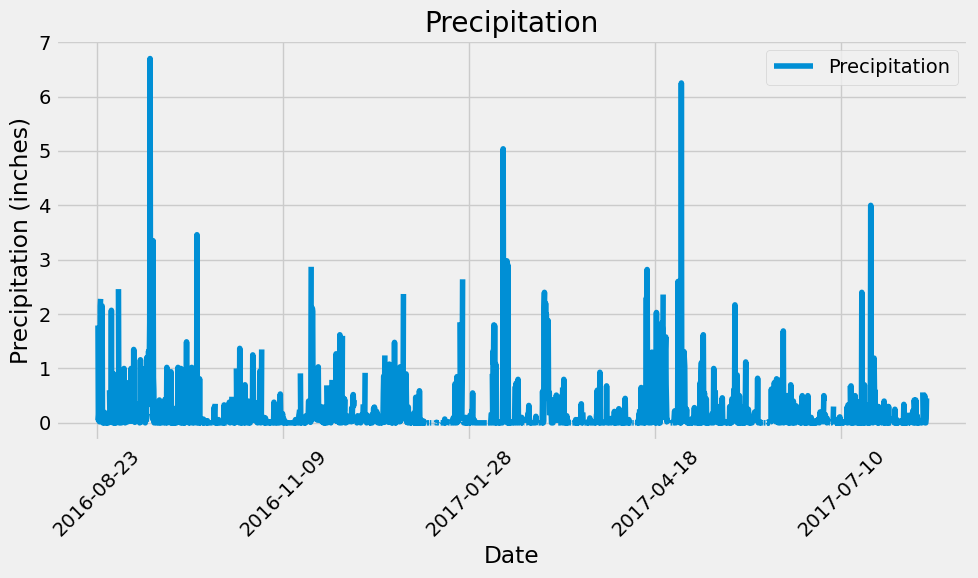

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in the dataset
one_year_ago = dt.date.fromisoformat(recent_date) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame, explicitly set the column names
precipitation_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['Precipitation'].describe(include=[np.number])

summary_stat

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()

total_stations

[(9,)]

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)) \
                                .group_by(Measurement.station) \
                                .order_by(func.count(Measurement.station).desc()) \
                                .all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = active_stations[0][0]


temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                            .filter(Measurement.station == most_active_station_id) \
                            .all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

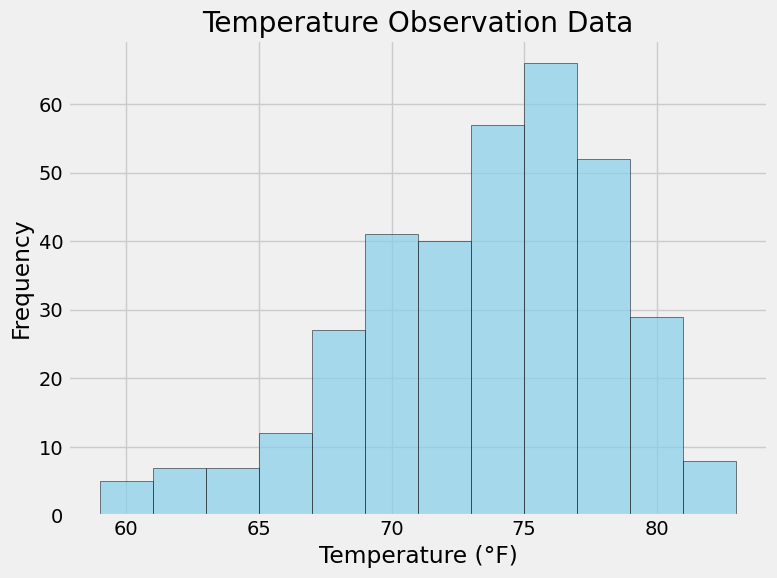

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from datetime import datetime, timedelta
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
one_year_ago = last_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs) \
                          .filter(Measurement.station == most_active_station_id) \
                          .filter(Measurement.date >= one_year_ago) \
                          .all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['Temperature'], bins=12, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()